In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _calculate_gini(self, y):
        """Calculate Gini impurity of a node"""
        proportions = np.bincount(y) / len(y)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def _split_data(self, X, y, feature, threshold):
        """Split the data based on a feature and threshold"""
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _best_split(self, X, y):
        """Find the best split for a node"""
        num_samples, num_features = X.shape
        best_gain = -1
        best_split = {}

        parent_gini = self._calculate_gini(y)

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split_data(X, y, feature, threshold)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gini_left = self._calculate_gini(y_left)
                gini_right = self._calculate_gini(y_right)

                n_left, n_right = len(y_left), len(y_right)
                gini_split = (n_left * gini_left + n_right * gini_right) / num_samples

                info_gain = parent_gini - gini_split

                if info_gain > best_gain:
                    best_gain = info_gain
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'X_left': X_left,
                        'X_right': X_right,
                        'y_left': y_left,
                        'y_right': y_right,
                        'gain': info_gain
                    }

        return best_split

    def _most_common_label(self, y):
        """Return the most common label in a node"""
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           num_samples < self.min_samples_split or \
           num_classes == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_split = self._best_split(X, y)

        if not best_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._build_tree(best_split['X_left'], best_split['y_left'], depth + 1)
        right = self._build_tree(best_split['X_right'], best_split['y_right'], depth + 1)

        return Node(
            feature=best_split['feature'],
            threshold=best_split['threshold'],
            left=left,
            right=right
        )

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        """Traverse the tree to make a prediction for a single sample"""
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def visualize_tree(self, node=None, depth=0, feature_names=None):
        if node is None:
            node = self.root

        if node.value is not None:
            print('  ' * depth + f'Predict: {node.value}')
            return

        feature_name = f'Feature {node.feature}' if feature_names is None else feature_names[node.feature]
        print('  ' * depth + f'{feature_name} <= {node.threshold}')

        print('  ' * depth + '--> True:')
        self.visualize_tree(node.left, depth + 1, feature_names)

        print('  ' * depth + '--> False:')
        self.visualize_tree(node.right, depth + 1, feature_names)

In [4]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_split=2)
dt.fit(X_train, y_train)

In [5]:
y_pred = dt.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 1.0000


In [6]:
print("Decision Tree Structure:")
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
dt.visualize_tree(feature_names=feature_names)

Decision Tree Structure:
Feature 0 <= -0.49385699654064075
--> True:
  Predict: 1
--> False:
  Predict: 0


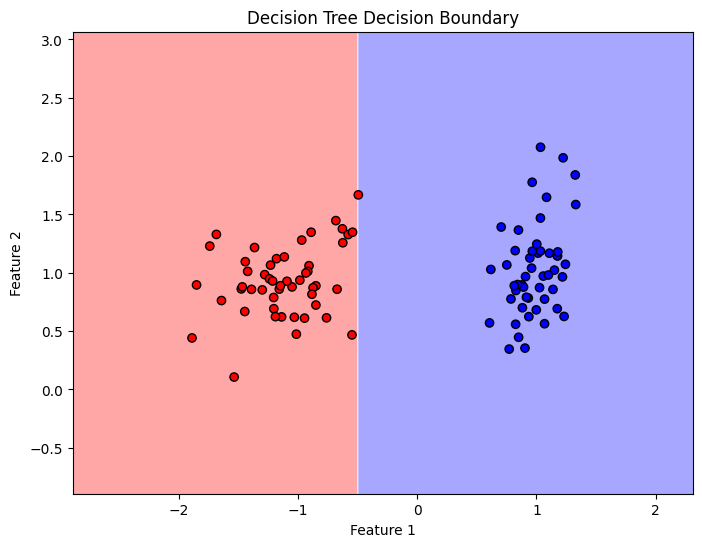

In [7]:
def plot_decision_boundary(X, y, classifier, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='bwr')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(X, y, dt, "Decision Tree Decision Boundary")